In [1]:
%matplotlib inline
import os
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

from utils.utils import unilateral_normalize, bilateral_normalize

## Load Data

In [2]:
# Load node ids
idx_train = pd.read_csv('data/train.csv')['Id'].values.ravel()
idx_test = pd.read_csv('data/test.csv')['Id'].values.ravel()
idx_allnodes = np.hstack([idx_train, idx_test])
print(len(idx_allnodes), len(idx_train), len(idx_test))

# Build adjacency matrix
edges_tbl = pd.read_csv('data/edges.csv')
edges_tbl.head()

16466 3293 13173


,Source,Target,Weight
0,13624,14622,2
1,2071,8198,1
2,4603,4021,1
3,7200,14485,1
4,1326,10355,3


In [3]:
row, col = edges_tbl['Source'].values, edges_tbl['Target'].values
weight = edges_tbl['Weight'].values
sp_adj = sp.csr_matrix((weight,(row, col)), shape=((len(idx_allnodes),)*2))
sp_adj = bilateral_normalize(sp_adj + sp.eye(sp_adj.shape[0]))
# sp_adj[13624, 14622], sp_adj[2071, 8198]
sp_adj[:,0]

<16466x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [4]:
# Load labels
raw_labels = pd.read_csv('data/train.csv').values
id2labels = {row[0]:row[1:].tolist() for row in raw_labels}
labels = np.zeros((len(idx_allnodes), raw_labels.shape[1] - 1))
labels[list(id2labels.keys())] = np.asarray(list(id2labels.values()))
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# Load node features
with open('data/node_info.json') as f:
    node_features = json.load(f)
features = {int(k):v for k,v in node_features.items()}
len(features)

16466

In [6]:
features

{0: {'PaperCount': 36,
  'CitationCountInAI': 874,
  'Affiliation': [{'AffiliationID': 608, 'PaperCount': 4}]},
 1: {'PaperCount': 40,
  'CitationCountInAI': 1301,
  'Affiliation': [{'AffiliationID': 1466, 'PaperCount': 1},
   {'AffiliationID': 3075, 'PaperCount': 9},
   {'AffiliationID': 1334, 'PaperCount': 10}]},
 2: {'PaperCount': 12,
  'CitationCountInAI': 8,
  'Affiliation': [{'AffiliationID': 1334, 'PaperCount': 5}]},
 3: {'PaperCount': 34,
  'CitationCountInAI': 40,
  'Affiliation': [{'AffiliationID': 2407, 'PaperCount': 10},
   {'AffiliationID': 2855, 'PaperCount': 5}]},
 4: {'PaperCount': 22,
  'CitationCountInAI': 22,
  'Affiliation': [{'AffiliationID': 1826, 'PaperCount': 2},
   {'AffiliationID': 1540, 'PaperCount': 1},
   {'AffiliationID': 432, 'PaperCount': 3},
   {'AffiliationID': 102, 'PaperCount': 1},
   {'AffiliationID': 2540, 'PaperCount': 2},
   {'AffiliationID': 4386, 'PaperCount': 2},
   {'AffiliationID': 3383, 'PaperCount': 1}]},
 5: {'PaperCount': 24,
  'Citation

In [7]:
# Convert features to sparse

# Get unique aff ids
affs = list()
for _, feat in features.items():
    for aff in feat['Affiliation']:
        affs.append(aff['AffiliationID'])
print(max(set(affs)))

rows, cols, datas = [], [], []
for id, feat in features.items():
    rows.append(id)
    cols.append(0)
    datas.append(feat['PaperCount'])
    rows.append(id)
    cols.append(1)
    datas.append(feat['CitationCountInAI'])
    for aff in feat['Affiliation']:
        rows.append(id)
        cols.append(aff['AffiliationID'] + 2)
        datas.append(aff['PaperCount'])
print(len(rows), len(cols), len(datas))
print(max(cols), max(rows))
sp_features = sp.csr_matrix((datas, (rows, cols)), shape=(len(idx_allnodes), max(set(affs)) + 3),  dtype=np.float32)
sp_features = unilateral_normalize(sp_features)
sp_features

4580
91590 91590 91590
4582 16465


<16466x4583 sparse matrix of type '<class 'numpy.float32'>'
	with 90955 stored elements in Compressed Sparse Row format>

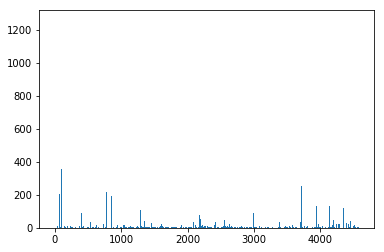

In [8]:
aff_cnts = plt.hist(affs, bins=len(set(affs)))[0]

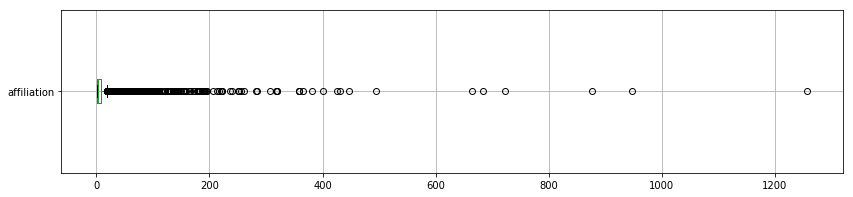

In [9]:
aff_cnts = pd.DataFrame(data=aff_cnts, columns=[['affiliation']])
aff_cnts.boxplot(column=['affiliation'], figsize=(14,3), vert=False)

In [10]:
sum(aff_cnts.values>8)

array([1087])

## Build Graph

In [11]:
graph = nx.DiGraph()
graph.add_nodes_from(sorted(idx_allnodes))
graph.add_weighted_edges_from(list(map(tuple, edges_tbl.values)))
graph.number_of_nodes(), graph.number_of_edges()

(16466, 364700)

## Statistics

           indegree     outdegree
count  16466.000000  16466.000000
mean      22.148670     22.148670
std       67.072897     41.800213
min        0.000000      0.000000
25%        1.000000      3.000000
50%        5.000000      9.000000
75%       16.000000     24.000000
max     2079.000000    916.000000


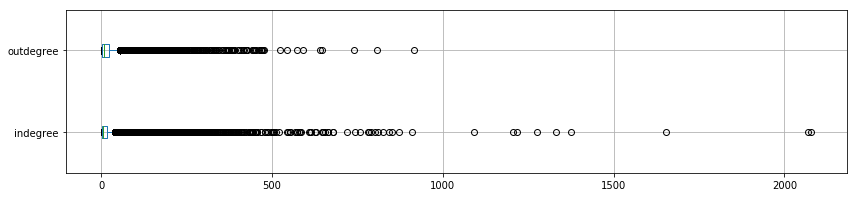

In [12]:
od = np.array(list(dict(graph.out_degree()).values())).reshape((-1,1))
id = np.array(list(dict(graph.in_degree()).values())).reshape((-1,1))
deg = pd.DataFrame(data=np.hstack([id, od]), columns=[['indegree', 'outdegree']])
print(deg.describe())
_ = deg.boxplot(column=['indegree', 'outdegree'], figsize=(14,3), vert=False)

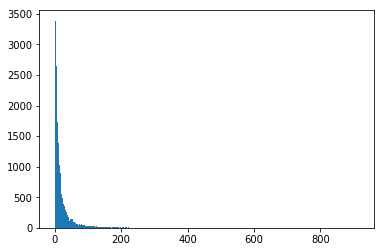

In [13]:
_ = plt.hist(deg['outdegree'].values, bins=len(set(deg['outdegree'].values.ravel().tolist())))

(0, 2500)

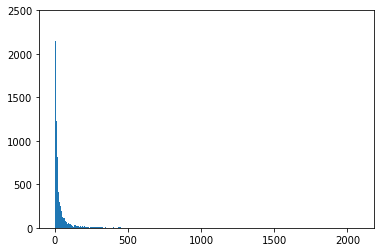

In [14]:
_ = plt.hist(deg['indegree'].values, bins=len(set(deg['indegree'].values.ravel().tolist())))
plt.ylim([0,2500])

In [15]:
sum(deg['outdegree'].values==0), sum(deg['indegree'].values==0), sum(np.logical_and(deg['indegree'].values==0, deg['outdegree'].values==0))

(array([1297]), array([3720]), array([0]))

In [16]:
sum(labels[(deg['outdegree'].values==0).ravel(),:].sum(1) == 0), sum(labels[(deg['indegree'].values==0).ravel(),:].sum(1) == 0)

(1040, 2992)

In [17]:
data = np.hstack([sp_features.todense(), labels])
columns = ['PaperCount', 'CitationCountInAI']\
+ ['Affilation{}'.format(id) for id in range(4581)]\
+ ['Conf{}'.format(id) for id in range(8)]
data = pd.DataFrame(data=data, columns=columns)
data.head()

,PaperCount,CitationCountInAI,Affilation0,Affilation1,Affilation2,Affilation3,Affilation4,Affilation5,Affilation6,Affilation7,...,Affilation4579,Affilation4580,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
0,0.039387,0.956236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.029390,0.955915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.480000,0.320000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.382022,0.449438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.392857,0.392857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
lbs = pd.read_csv('data/train.csv')
transfer_proba = np.zeros((8,8)).astype(np.float)
for i in range(8):
    for j in range(8):
        lb1 = 'Conf' + str(i)
        lb2 = 'Conf' + str(j)
        transfer_proba[i,j] = len(lbs[(lbs[lb1] == 1) & (lbs[lb2] == 1)]) / lbs[lb1].sum()
transfer_proba = pd.DataFrame(data=transfer_proba, columns=list(range(8)))
transfer_proba

,0,1,2,3,4,5,6,7
0,1.000000,0.096977,0.128463,0.094458,0.089421,0.037783,0.099496,0.372796
1,0.130508,1.000000,0.038983,0.159322,0.027119,0.254237,0.271186,0.118644
2,0.243437,0.054893,1.000000,0.131265,0.408115,0.035800,0.050119,0.186158
3,0.145349,0.182171,0.106589,1.000000,0.060078,0.065891,0.153101,0.112403
4,0.123264,0.027778,0.296875,0.053819,1.000000,0.019097,0.022569,0.097222
5,0.075000,0.375000,0.037500,0.085000,0.027500,1.000000,0.232500,0.070000
6,0.104636,0.211921,0.027815,0.104636,0.017219,0.123179,1.000000,0.080795
7,0.461778,0.109204,0.121685,0.090484,0.087363,0.043682,0.095164,1.000000


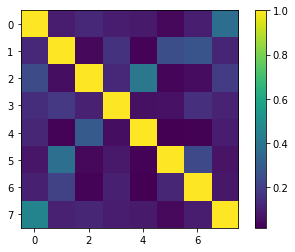

In [19]:
plt.imshow(transfer_proba.values)
plt.colorbar()

In [20]:
lb_corr = lbs.iloc[:,1:].corr()
lb_corr

,Conf0,Conf1,Conf2,Conf3,Conf4,Conf5,Conf6,Conf7
Conf0,1.000000,-0.120807,0.002070,-0.096507,-0.126855,-0.144401,-0.174021,0.253610
Conf1,-0.120807,1.000000,-0.123735,0.003375,-0.181764,0.189881,0.046582,-0.089693
Conf2,0.002070,-0.123735,1.000000,-0.026712,0.234382,-0.100134,-0.162729,-0.008195
Conf3,-0.096507,0.003375,-0.026712,1.000000,-0.130305,-0.073338,-0.078111,-0.089549
Conf4,-0.126855,-0.181764,0.234382,-0.130305,1.000000,-0.144290,-0.226407,-0.113305
Conf5,-0.144401,0.189881,-0.100134,-0.073338,-0.144290,1.000000,0.002853,-0.117069
Conf6,-0.174021,0.046582,-0.162729,-0.078111,-0.226407,0.002853,1.000000,-0.156847
Conf7,0.253610,-0.089693,-0.008195,-0.089549,-0.113305,-0.117069,-0.156847,1.000000


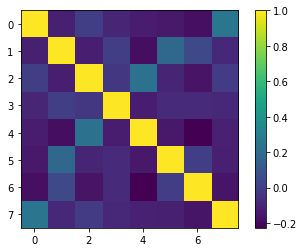

In [21]:
plt.imshow(lb_corr.values)
plt.colorbar()

In [22]:
# cor = data.corr()
# cor.to_csv('corr.csv', index=False)

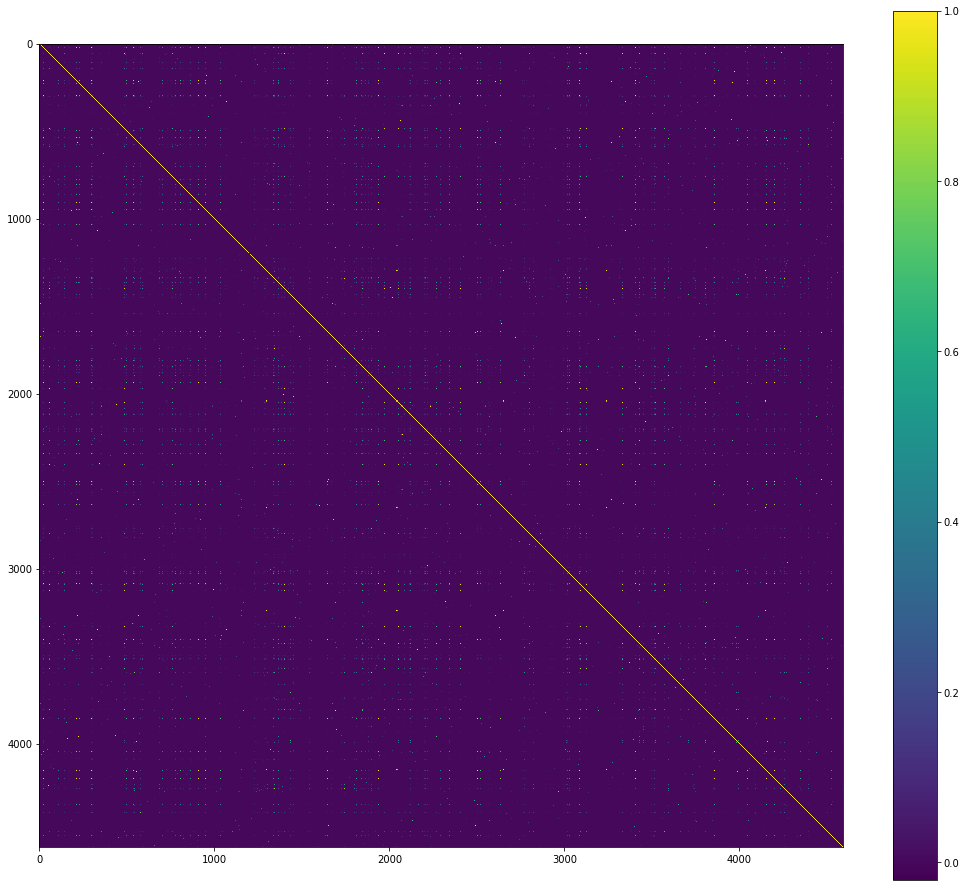

In [23]:
corr = pd.read_csv('data/corr.csv').values
fig = plt.figure(figsize=(18,16))
plt.imshow(corr)
plt.colorbar()

## Visualize Subgraph

In [24]:
sub_nodes = idx_train[:int(len(idx_train) * 0.2)].copy()
sub_nodes_map = dict(list(map(lambda n:(n[1],n[0]), enumerate(sub_nodes))))
sub_edges = list(filter(lambda e: e[0] in sub_nodes and e[1] in sub_nodes, iter(edges_tbl.values)))
sub_edges = list(map(lambda e: [sub_nodes_map[e[0]], sub_nodes_map[e[1]], e[2]], iter(sub_edges)))
sub_nodes = list(sub_nodes_map.values())

subg = nx.DiGraph()
subg.add_nodes_from(sorted(sub_nodes))
subg.add_weighted_edges_from(list(map(tuple, sub_edges)))
subg.number_of_nodes(), graph.number_of_edges()

(658, 364700)

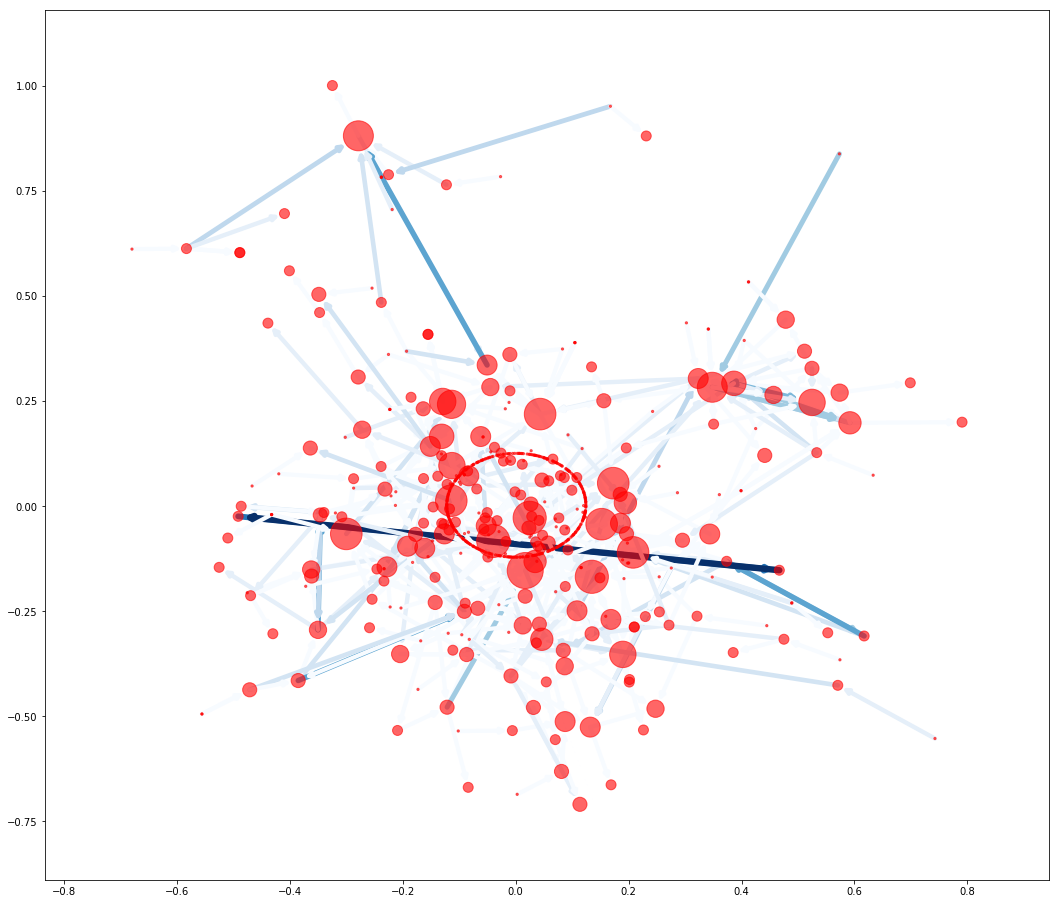

In [25]:
fig = plt.figure(figsize=(18,16))
pos = nx.kamada_kawai_layout(subg)
node_size = list(map(lambda s:s*100 if s else 5, list(dict(subg.in_degree()).values())))
edge_width = list(map(lambda e:e[-1]['weight']*0.2+4, iter(subg.edges(data=True))))
edge_color = edge_width
nx.draw_networkx(subg, 
                 pos=pos,
                 node_color='r',
                 node_size=node_size, 
                 alpha=0.6,
                 width=edge_width,
                 edge_cmap = plt.cm.Blues,
                 edge_color = edge_color,
                 with_labels=False)